In [5]:
import scipy.io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_style("darkgrid")
import scipy
import math
import zlib
from scipy import stats
from scipy import signal
from itertools import *
sns.plt = plt
np.random.seed(1) # No estoy seguro si es necesario

In [228]:
# Carga de datos

# datasets_sujetos: (Sujeto x Epoch x Electrodo x Tiempo -> Valor)
datasets_sujetos = []

# # Solo 2 datasets, para probar
# datasets_sujetos.append(scipy.io.loadmat('datos/S01.mat')['data'])
# datasets_sujetos.append(scipy.io.loadmat('datos/P01.mat')['data'])

# Normales
for i in range(1,10):
    datasets_sujetos.append(scipy.io.loadmat('datos/S0'+str(i)+'.mat')['data'])
datasets_sujetos.append(scipy.io.loadmat('datos/S10.mat')['data'])

# Disminuidos
for i in range(1,10):
    datasets_sujetos.append(scipy.io.loadmat('datos/P0'+str(i)+'.mat')['data'])
datasets_sujetos.append(scipy.io.loadmat('datos/P10.mat')['data'])

In [410]:
print 'Se cargaron '+ str(len(datasets_sujetos)) + ' datasets.'

Se cargaron 20 datasets.


In [157]:
# Dado un dataset de (Epoch x Electrodo x Tiempo -> Valor) devuelve
# otro de la misma forma pero solo con los electrodos importantes
def electrodos_importantes(dataset):
    return dataset[:, [7, 43, 79, 130, 184], :]

In [168]:
# Dado un dataset de (Epoch x Electrodo x Tiempo -> Valor)
# devuelve la cantidad de epochs
def epoch_count(dataset):
    return len(dataset)

# Dado un dataset de (Epoch x Electrodo x Tiempo -> Valor)
# devuelve la cantidad de electrodos
def electrodos_count(dataset):
    return len(dataset[0])

# Dado un dataset de (Epoch x Electrodo x Tiempo -> Valor)
# devuelve la cantidad de tiempos
def tiempo_count(dataset):
    return len(dataset[0][0])

# Dado un dataset de (Epoch x Electrodo x Tiempo -> Valor) devuelve una lista de 
# (Epoch x Tiempo -> Valor) promediando para cada epoch y tiempo, los valores de los electrodo
def average_by_epoch(dataset):
    return [[np.mean(dataset[epoch,:,tiempo]) 
             for tiempo in range(tiempo_count(dataset))] 
            for epoch in range(epoch_count(dataset))]

In [159]:
# Dada una lista zipeada de [(a,b)] devuelve una tupla de lista ([a],[b])
def unzip(iterable):
    return zip(*iterable)

# Dadas dos listas de freqs y pots emparentadas devuelve las listas
# sacando los pares donde las frecuencias son mayores a 45.0
def freq_pots_relevantes(freqs, pots):
    pairs_relevantes = filter(lambda x: x[0] <= 45.0, zip(freqs, pots))
    return unzip(pairs_relevantes)

In [160]:
def graph_fft(dataset):
    averaged_electrodes_by_epoch = average_by_epoch(dataset)
    allEpochs = pd.DataFrame([]);
    for i in range(epoch_count(dataset)):
        epoch_welch = scipy.signal.welch(averaged_electrodes_by_epoch[i], fs=250)
        (freqs_relevantes, pots_relevantes) = freq_pots_relevantes(epoch_welch[0], epoch_welch[1])
        allEpochs = allEpochs.append(pd.DataFrame([pots_relevantes], columns=freqs_relevantes))
    allEpochs = allEpochs.reset_index();
    ax = sns.heatmap(allEpochs.transpose(), cmap="viridis", fmt='.2g')
    ax.set_ylabel('Frecuencia')
    ax.set_xlabel('Epoch')
    for label in ax.get_xticklabels()[::2]:
        label.set_visible(False)
    ax.set_yticklabels([item.get_text()[0:4] for item in ax.get_yticklabels()])
    plt.rcParams['figure.figsize'] = 14, 6
    plt.xticks(rotation=0)
    plt.yticks(rotation=0)
    plt.show()
    del allEpochs

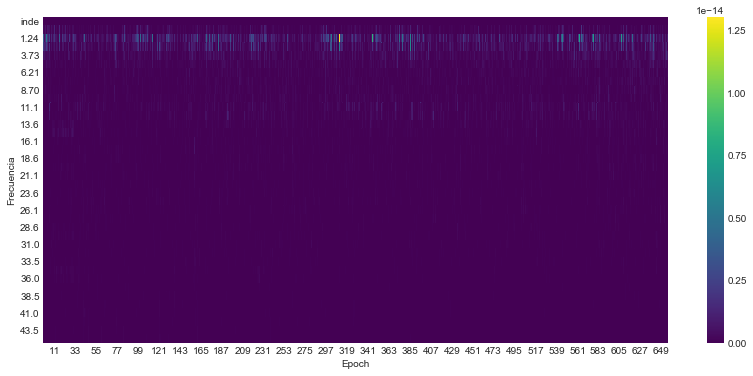

In [161]:
graph_fft(datasets_sujetos[0])

In [224]:
def get_epoch(epoch_idx,electrodo_idx, dataset):
    return dataset[epoch_idx, electrodo_idx, :]

def par_frecuencias_potencias_epoch(epoch_idx,electrodo_idx,dataset):
    welch_result = scipy.signal.welch(get_epoch(epoch_idx,electrodo_idx,dataset), fs=250)
    return freq_pots_relevantes(welch_result[0], welch_result[1])

# Dado un dataset y un electrodo devuelve una lista de potencias promedio para cada epoch
def potencias_promedio(electrodo_idx,dataset):
    freqs_pots_por_epoch = [par_frecuencias_potencias_epoch(i,electrodo_idx, dataset) for i in range(epoch_count(dataset))]
    res = pd.DataFrame([])
    for i in range(len(freqs_pots_por_epoch)):
        res = res.append(pd.DataFrame([freqs_pots_por_epoch[i][1]], columns=freqs_pots_por_epoch[i][0]))
    return res.mean()

def graph_potencias(dataset):
    colors = sns.color_palette('muted', n_colors=electrodos_count(dataset))
    for i in range(electrodos_count(dataset)):
        ax = sns.tsplot(potencias_promedio(i, dataset), color=colors[i])
        ax.set_ylabel('Potencia(V^2/Hz)')
        ax.set_xlabel('Frecuencia(Hz)')
    plt.show()

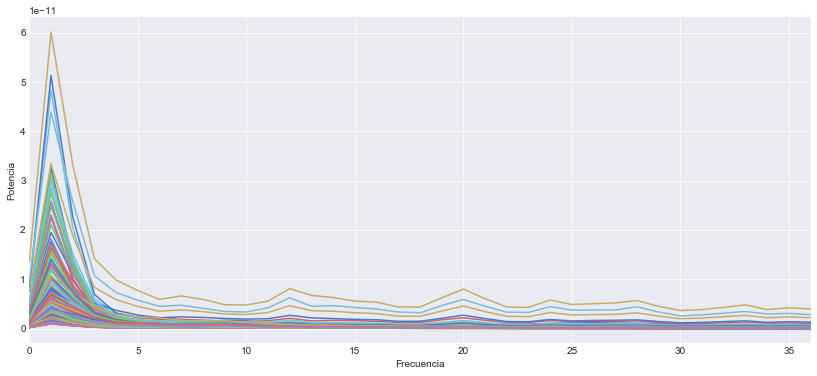

In [226]:
graph_potencias(datasets_sujetos[0])

In [390]:
def potencia_banda(low, high, potencias_promedio, frecuencias):
    # Thomas dice np.average
    return np.average(map(lambda x: x[0], ifilter(lambda x: x[1] >= low and x[1] < high, izip(potencias_promedio, frecuencias))))

# Esto tarda mucho, puse que cargue solo 2 electrodos para que sea facil de modificar y volver a correr
def get_bandas_dict(dataset):
    potencias_promedio_by_electrode = pd.DataFrame([])
    for i in range(2):
#         electrodos_count(dataset)):
        pp = potencias_promedio(i, dataset)
        potencias_promedio_by_electrode = potencias_promedio_by_electrode.append(pd.Series.to_frame(pp))
    potencias_promedio_total = potencias_promedio_by_electrode.groupby(level=0).mean()
    del potencias_promedio_by_electrode
    potencias = potencias_promedio_total.values
    frecuencias = potencias_promedio_total.index.values.tolist()
    res = {}
    res['delta'] = potencia_banda(0., 4.0, potencias, frecuencias)
    res['theta'] = potencia_banda(4.0, 8.0, potencias, frecuencias)
    res['alpha'] = potencia_banda(8.0, 13.0, potencias, frecuencias)
    res['beta'] = potencia_banda(13.0, 30., potencias, frecuencias)
    res['gamma'] = potencia_banda(30.0, 125., potencias, frecuencias)
    return res

In [ ]:
import math
import zlib
def to_symb(l):
    maxi = np.max(l)
    mini = np.min(l)
    def scott_N():
        std = np.std(l)
        n = float(len(l))
        return int(math.ceil((maxi - mini) / (3.5 * std * (n**(-1./3.)))))
    
    N = scott_N()
    bin_size = (maxi - mini) / float(N) 
    for x in l:
        if x == maxi:
            yield N - 1
        else:
            symbol = int((x - mini) / bin_size)
            yield symbol
            
            
def to_str_symb(l):
    return ''.join(imap(str, to_symb(l)))

def kolmog_approx(l):
    compressed = zlib.compress(to_str_symb(l), 9)
    return len(compressed)

In [ ]:
x = [-7.3, -6.2, 3.4, 2.1, 0.2, 9.2]
print list(to_symb(x))

print to_str_symb(x)


print kolmog_approx(x)

In [ ]:
def info_intra_electrodo(dataset):
    total = 0.
    for i in range(epoch_count(dataset)):
        for j in range(electrodes_count(dataset)):
            total += kolmog_approx(get_epoch(i, j, dataset))
    promedio = float(total) / float(epoch_count(dataset) * electrodes_count(dataset))
    return promedio

In [395]:
bandas_frame_columns = ['delta','theta','alpha','beta','gamma','tipo']
bandas_frame = pd.DataFrame(data=[], columns=bandas_frame_columns)

for dataset_index in range(len(datasets_sujetos)):
    bandas_dict = get_bandas_dict(datasets_sujetos[dataset_index])
    if dataset_index < len(datasets_sujetos)/2:
        bandas_dict['tipo'] = 'normal'
    else:
        bandas_dict['tipo'] = 'disminuido'
    bandas_dict['info_intra'] = info_intra_electrodo(dataset)
    bandas_sujeto = pd.DataFrame(data=[bandas_dict], columns=bandas_frame_columns)
    bandas_frame = bandas_frame.append(bandas_sujeto)

In [396]:
print bandas_frame

          delta         theta         alpha          beta         gamma  \
0  6.147577e-12  1.049105e-12  7.204780e-13  2.543561e-13  1.085022e-13   
0  3.939157e-12  1.375420e-12  4.535576e-12  2.987882e-13  1.067063e-13   
0  5.298040e-12  9.730489e-13  2.720670e-12  1.642176e-13  4.448524e-14   
0  7.161299e-12  1.992715e-12  6.658683e-12  2.826787e-13  1.008991e-13   
0  4.437953e-12  2.453755e-12  1.670989e-12  2.121418e-13  4.100464e-14   
0  4.268734e-12  1.050228e-12  1.549149e-12  2.933514e-13  1.142923e-13   
0  6.720159e-12  9.259624e-13  4.524279e-12  3.257793e-13  1.261440e-13   
0  3.943642e-12  1.226176e-12  3.556721e-12  9.086678e-13  6.923813e-13   
0  3.612058e-11  1.535283e-11  1.174695e-11  3.148195e-12  5.196570e-13   
0  6.624751e-12  1.145561e-12  5.947950e-13  2.024102e-13  1.259634e-13   
0  2.354833e-11  2.212192e-12  7.179435e-13  3.150962e-13  2.196442e-13   
0  1.865747e-11  4.110057e-12  7.008357e-13  2.825934e-13  1.349632e-13   
0  3.724250e-11  2.632429

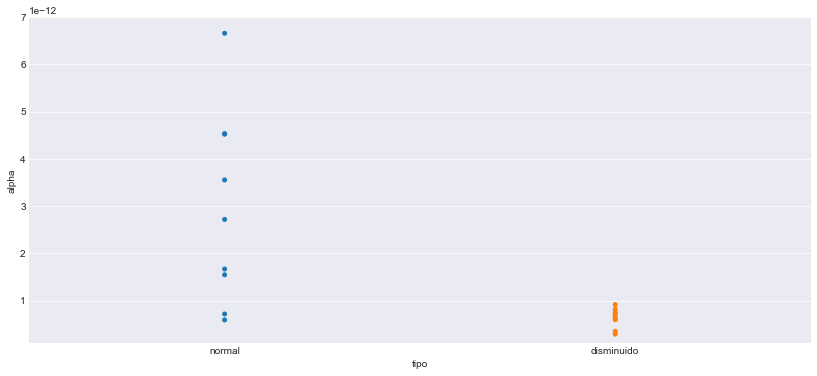

In [397]:
sns.stripplot(data=bandas_frame, y="alpha", x="tipo")
plt.ylim(1e-13, 7e-12)
plt.show()

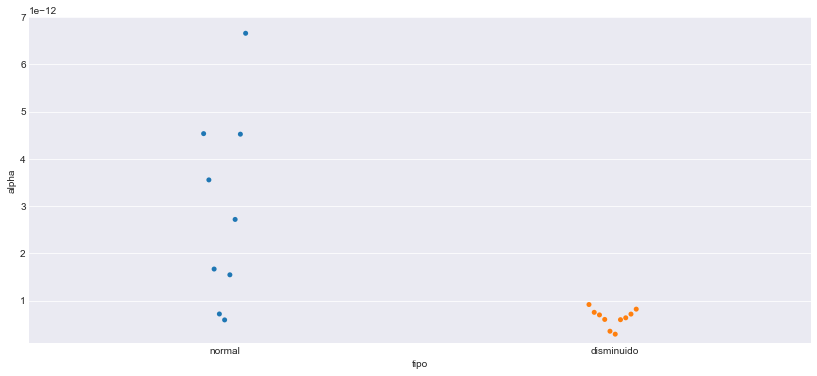

In [398]:
sns.swarmplot(x="tipo", y="alpha", data=bandas_frame)
plt.ylim(1e-13, 7e-12)
plt.show()

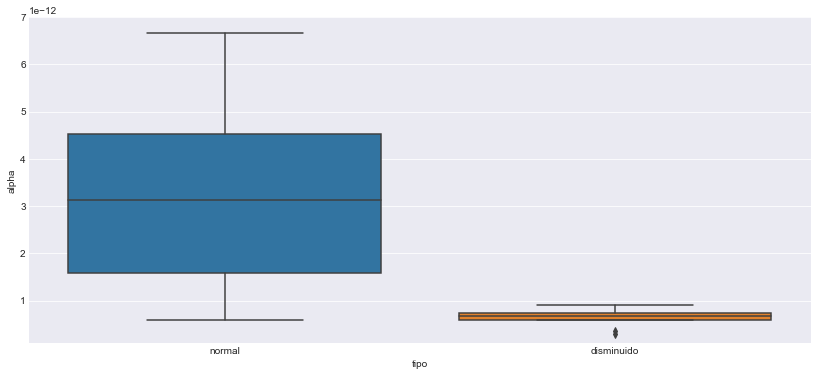

In [399]:
sns.boxplot(x="tipo", y="alpha", data=bandas_frame)
plt.ylim(1e-13, 7e-12)
plt.show()

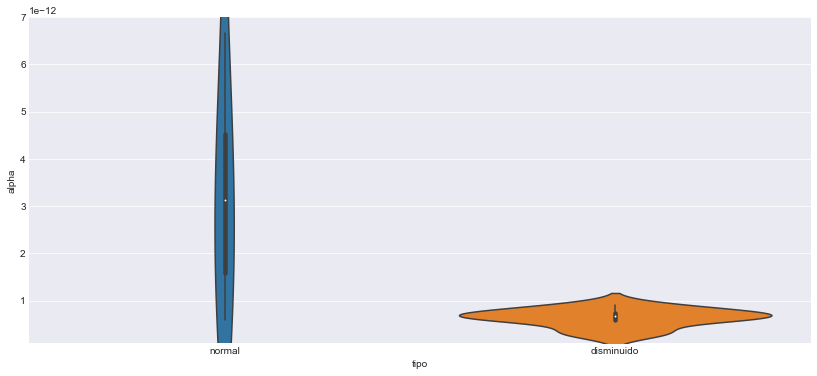

In [400]:
sns.violinplot(x="tipo", y="alpha", data=bandas_frame)
plt.ylim(1e-13, 7e-12)
plt.show()

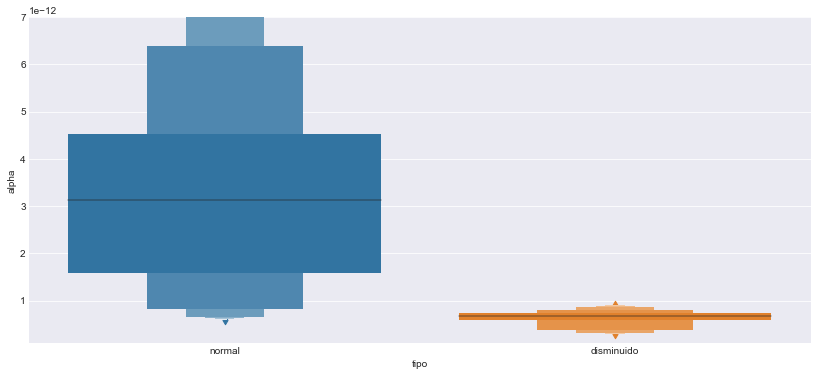

In [401]:
sns.lvplot(x="tipo", y="alpha", data=bandas_frame)
plt.ylim(1e-13, 7e-12)
plt.show()

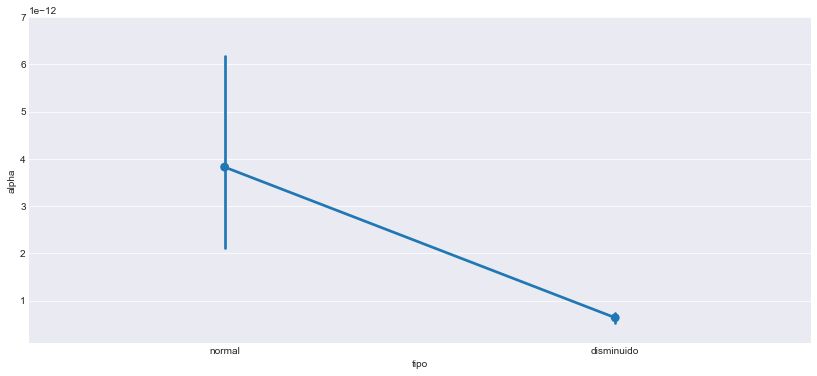

In [402]:
sns.pointplot(x="tipo", y="alpha", data=bandas_frame)
plt.ylim(1e-13, 7e-12)
plt.show()

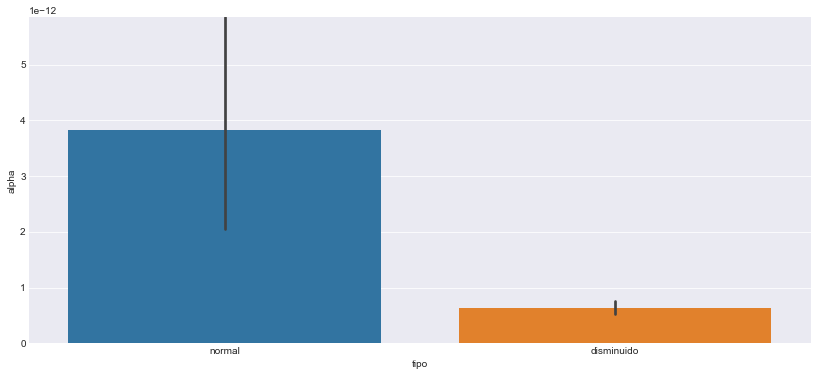

In [403]:
sns.barplot(x="tipo", y="alpha", data=bandas_frame)
plt.show()

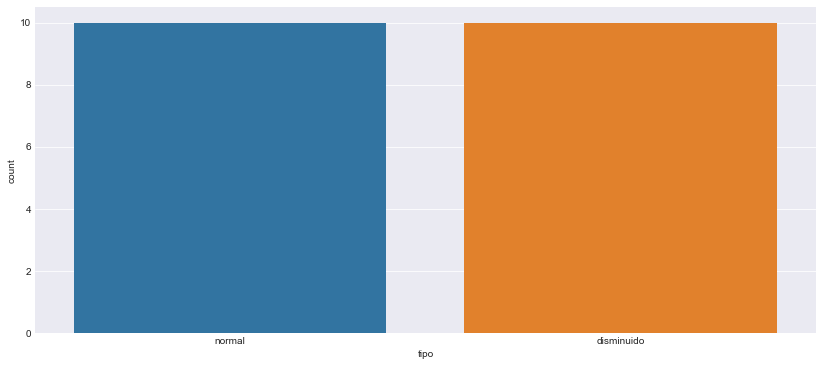

In [404]:
sns.countplot(x="tipo" ,data=bandas_frame)
plt.show()


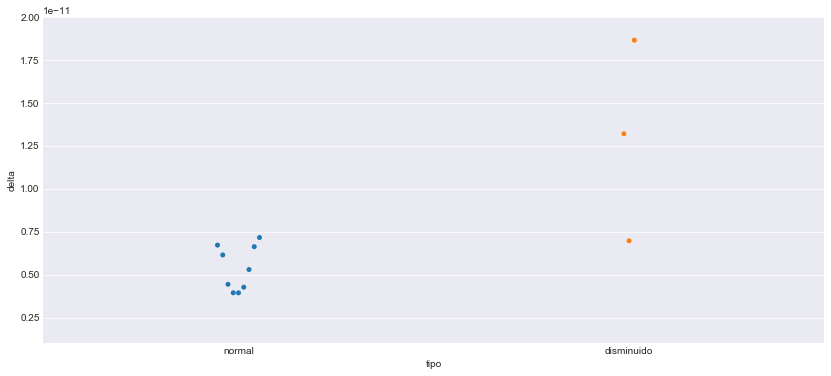

In [405]:
sns.swarmplot(x="tipo", y="delta", data=bandas_frame)
plt.ylim(1e-12, 2e-11)
plt.show()

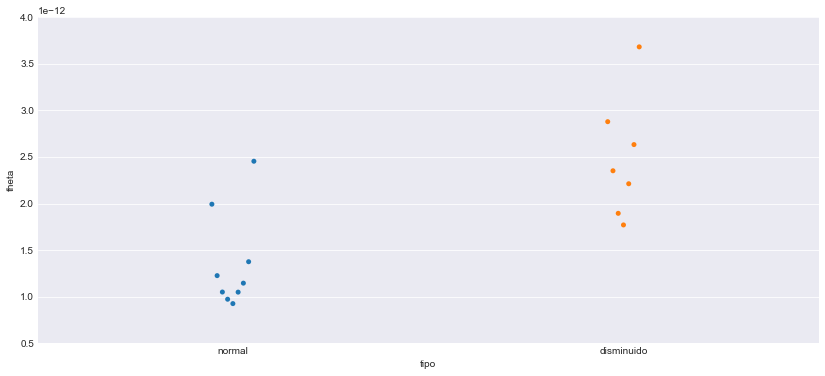

In [406]:
sns.swarmplot(x="tipo", y="theta", data=bandas_frame)
plt.ylim(5e-13, 4e-12)
plt.show()

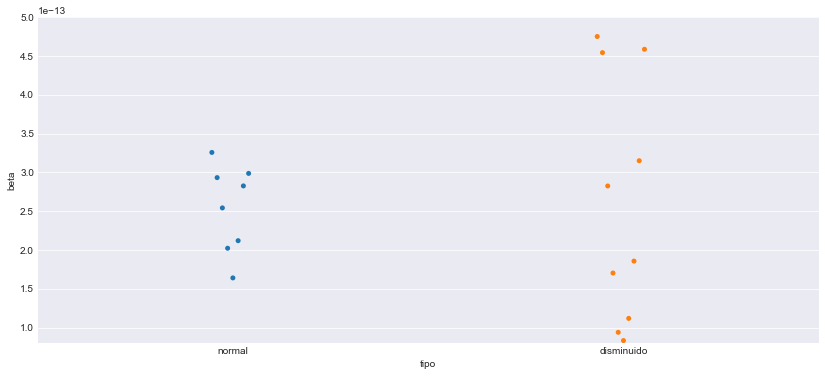

In [407]:
sns.swarmplot(x="tipo", y="beta", data=bandas_frame)
plt.ylim(8e-14, 5e-13)
plt.show()

In [408]:
print bandas_frame

          delta         theta         alpha          beta         gamma  \
0  6.147577e-12  1.049105e-12  7.204780e-13  2.543561e-13  1.085022e-13   
0  3.939157e-12  1.375420e-12  4.535576e-12  2.987882e-13  1.067063e-13   
0  5.298040e-12  9.730489e-13  2.720670e-12  1.642176e-13  4.448524e-14   
0  7.161299e-12  1.992715e-12  6.658683e-12  2.826787e-13  1.008991e-13   
0  4.437953e-12  2.453755e-12  1.670989e-12  2.121418e-13  4.100464e-14   
0  4.268734e-12  1.050228e-12  1.549149e-12  2.933514e-13  1.142923e-13   
0  6.720159e-12  9.259624e-13  4.524279e-12  3.257793e-13  1.261440e-13   
0  3.943642e-12  1.226176e-12  3.556721e-12  9.086678e-13  6.923813e-13   
0  3.612058e-11  1.535283e-11  1.174695e-11  3.148195e-12  5.196570e-13   
0  6.624751e-12  1.145561e-12  5.947950e-13  2.024102e-13  1.259634e-13   
0  2.354833e-11  2.212192e-12  7.179435e-13  3.150962e-13  2.196442e-13   
0  1.865747e-11  4.110057e-12  7.008357e-13  2.825934e-13  1.349632e-13   
0  3.724250e-11  2.632429

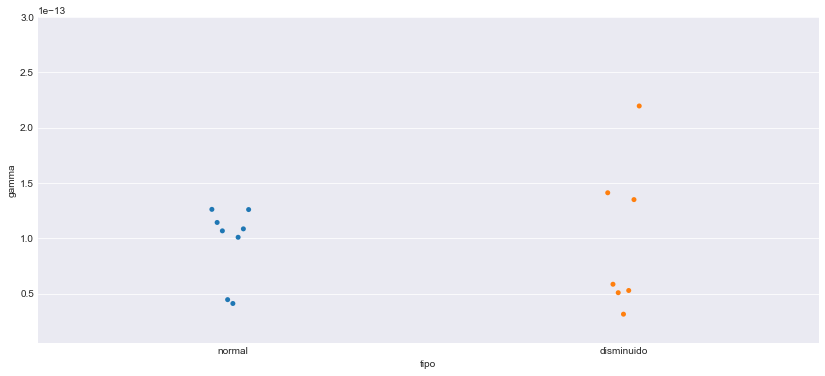

In [409]:
sns.swarmplot(x="tipo", y="gamma", data=bandas_frame)
plt.ylim(5e-15, 3e-13)
plt.show()

In [ ]:
sns.swarmplot(x="tipo", y="info_intra", data=bandas_frame)
plt.show()

In [14]:
from collections import Counter
input =  ['a', 'a', 'b', 'b', 'b']
c = Counter( input )

print( c.items() )

def entropy(l):
    def probability(l):
        c = Counter(l)
        total = len(l)
        for x in c.items():
            yield (x[0], float(x[1]/float(total)))
            
    prob_dict = dict(list(probability(l)))
    return -sum(imap(lambda x: prob_dict[x] * math.log(prob_dict[x], 2), l))

print entropy('0000000000000111')

[('a', 2), ('b', 3)]
4.52256407048
